In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from haversine import haversine, Unit
from torch_geometric.utils.convert import from_networkx, from_scipy_sparse_matrix
from torch_geometric_temporal.nn.recurrent import TGCN
import torch
import torch.nn.functional as F
import sys 
sys.path.append('..')
from utils import dataloader
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
dist_matrix = pd.read_csv('../data/distance_matrix.csv')
dist_matrix.head()
df = dataloader.load_data()

In [5]:
def get_graph(data, adjecency_threshold_km=3):
    G = nx.Graph()

    for cluster in data['Cluster'].unique():
        if 'SHERMAN' in cluster:
            continue
        G.add_node(cluster)
        G.nodes[cluster]['ID'] = dist_matrix.columns.get_loc('WEBSTER')
        G.nodes[cluster]['lat'] = df[df['Cluster'] == cluster]['Latitude'].mean()
        G.nodes[cluster]['long'] = df[df['Cluster'] == cluster]['Longitude'].mean()
        G.nodes[cluster]['pos'] = (G.nodes[cluster]['long'], G.nodes[cluster]['lat'])


    for node_x in G.nodes:
        for node_y in G.nodes:
            dist = haversine(
                (G.nodes[node_x]['lat'], G.nodes[node_x]['long']),
                (G.nodes[node_y]['lat'], G.nodes[node_y]['long']),
                unit=Unit.KILOMETERS)
            # Assume that if nodes are further than adjecency_threshold_km km apart, their usage are not correlated
            if (dist > adjecency_threshold_km):
                continue
            # We might have to avoid setting self-connections here, e.g if node_x == node_y then continue
            # This is because the GCN requires A and not A_hat
            G.add_edge(node_x, node_y)
            G[node_x][node_y]['weight'] = np.exp(-dist)


    adj = nx.adjacency_matrix(G)
    return G, adj
    #return G, normalize_adj(adj).todense()

In [6]:
G, adj = get_graph(df)
edge_index, edge_weight = from_scipy_sparse_matrix(adj)
edge_index, edge_weight, G.nodes

(tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
          4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
          7, 7, 7, 7, 7, 7],
         [0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 4, 5, 6, 7, 3, 6, 7,
          0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1,
          2, 3, 4, 5, 6, 7]]),
 tensor([1.0000, 0.7601, 0.7509, 0.1512, 0.6268, 0.1012, 0.0914, 0.7601, 1.0000,
         0.6967, 0.1174, 0.4962, 0.0945, 0.0881, 0.7509, 0.6967, 1.0000, 0.1272,
         0.6641, 0.0760, 0.0687, 1.0000, 0.0605, 0.0538, 0.1512, 0.1174, 0.1272,
         1.0000, 0.1769, 0.1420, 0.1073, 0.6268, 0.4962, 0.6641, 0.1769, 1.0000,
         0.0785, 0.0680, 0.1012, 0.0945, 0.0760, 0.0605, 0.1420, 0.0785, 1.0000,
         0.7429, 0.0914, 0.0881, 0.0687, 0.0538, 0.1073, 0.0680, 0.7429, 1.0000],
        dtype=torch.float64),
 NodeView(('HAMILTON', 'HIGH', 'BRYANT', 'MPL', 'RINCONADA', 'WEBSTER', 'TED', 'CAMBRIDGE')))

In [7]:
edge_weight.shape

torch.Size([54])

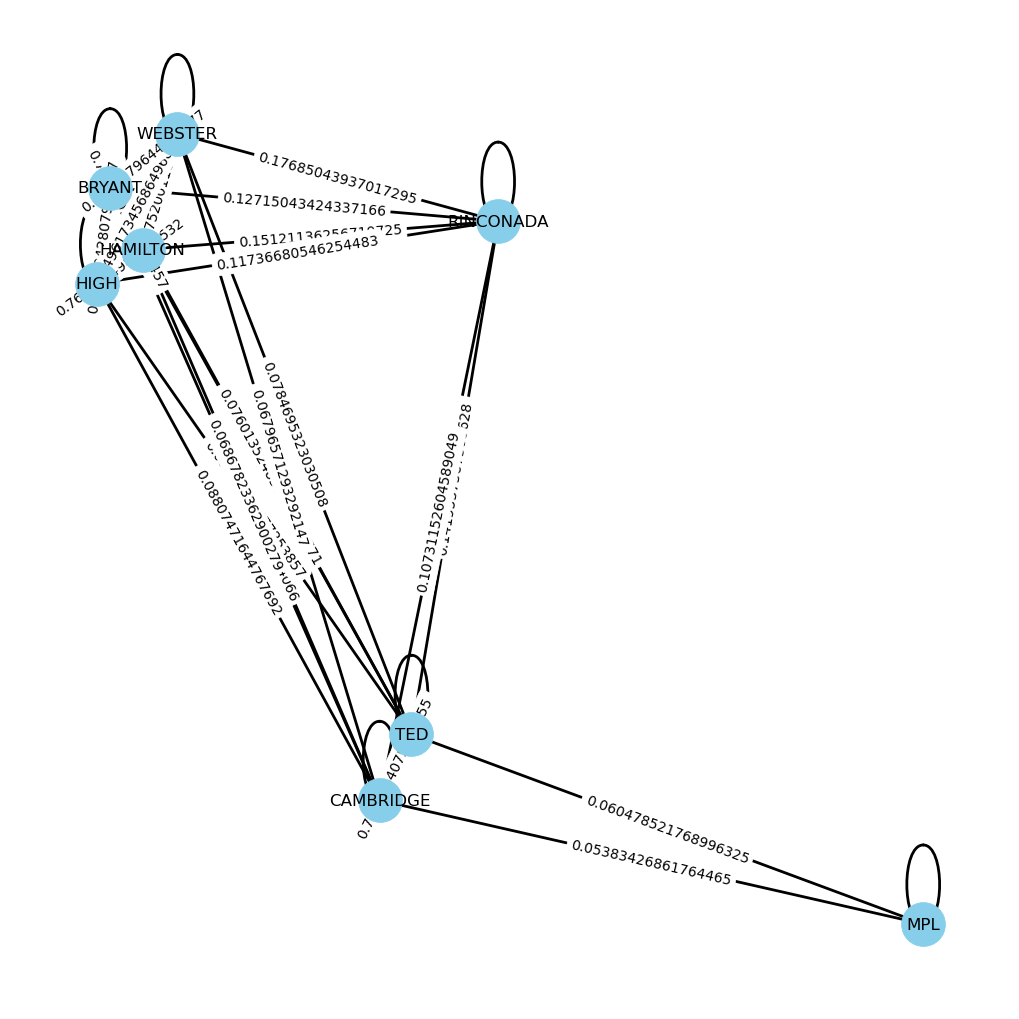

In [8]:
# plot graph
# Plot graph with edge weights
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', edge_cmap=plt.cm.Blues, width=2)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [9]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()
print(np.array(loader.features).shape)
print("snapshots:", len(loader.features))
print("nodes:", len(np.unique(loader._edges[0])))
print("lags:", np.array(loader.features).shape[2])
print("edges:", np.array(loader._edges).shape)
print("edge weights:", np.array(loader._edge_weights).shape)

(517, 20, 4)
snapshots: 517
nodes: 20
lags: 4
edges: (2, 102)
edge weights: (102,)


In [10]:
data = from_networkx(G)
data.edge_weight = edge_weight

In [11]:
df_sess = pd.read_csv('../data/charging_session_count_30.csv', parse_dates=['Period'])
df_sess = df_sess[df_sess['Period'] > '2019-01-01']

In [12]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col, axis=1, inplace=True)
    return data, [col + '_sin', col + '_cos']

,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
0,2011-07-29 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2011-07-29 20:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2011-07-29 21:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2011-07-29 21:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2011-07-29 22:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
156657,2020-07-05 12:30:00,0.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0
156658,2020-07-05 13:00:00,0.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
156659,2020-07-05 13:30:00,0.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0
156660,2020-07-05 14:00:00,0.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0


In [13]:
import numpy as np

def get_targets_and_features_tgcn(df, lags=30, add_month=True, add_week=True, add_day_of_week=True, add_year=True):
    df_test = df.copy()
    features, new_cols = [], []
    if add_month:
        df_test['month'] = df.Period.dt.month
        df_test, new_cols = cyclical_encode(df_test, 'month', 12)
        features = features + new_cols
    if add_day_of_week:
        df_test['dayofweek'] = df.Period.dt.dayofweek
        df_test, new_cols = cyclical_encode(df_test, 'dayofweek', 7)
        features = features + new_cols
    if add_week:
        df['hour'] = df.Period.dt.hour
        df_test, new_cols = cyclical_encode(df_test, 'hour', 24)
        features = features + new_cols
    if add_year:
        df_test['year'] = df.Period.dt.year - df.Period.dt.year.min()
        features.append('year')
    
    node_names = df_test.columns.difference(['Period'] + features)
    num_nodes = len(node_names)

    # Get initial lagged features
    sessions_array = np.array(df_test[node_names])
    lag_feats = np.array([
        sessions_array[i : i + lags, :].T
        for i in range(sessions_array.shape[0] - lags)
    ])
    lag_feats = lag_feats.reshape(-1, num_nodes, 1, lags)

    y = np.array([
        sessions_array[i + lags, :].T
        for i in range(sessions_array.shape[0] - lags)
    ])

    time_features = np.array(df_test[features], dtype=int)

    times = np.array([
        [time_features[i : i + lags, :].T]
        for i in range(time_features.shape[0] - lags)
    ])
    times = times.repeat(num_nodes, axis=1)
    
    # The `feat` matrix will go from (time_length, nodes, lags) to (time_length, nodes, number of features, lags)
    # We repeat the date-specific features 8 times because we have 8 nodes. 
    X = np.concatenate((lag_feats, times), axis=2)

    return X, y

In [14]:
feats, targets = get_targets_and_features_tgcn(df_sess, lags=30, add_month=True, add_day_of_week=True, add_week=True)
time_length, nodes, feature_num, lag = feats.shape
print(f"Time length: {time_length}, Nodes: {nodes}, Features: {feature_num}, Lag: {lag}")
feats.shape

Time length: 26447, Nodes: 8, Features: 6, Lag: 30


(26447, 8, 6, 30)

In [15]:
from torch_geometric_temporal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

dataset = StaticGraphTemporalSignal(
        data.edge_index, data.edge_weight.float(), feats, targets
    )
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
train_input = np.array(train_dataset.features) # (5289, 8, 8, 30)
train_target = np.array(train_dataset.targets) # (5289, 8)

train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)

train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True,drop_last=True)

In [17]:
from torch_geometric_temporal.nn.recurrent import TGCN2
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, hidden_dim, time_steps, batch_size=32):
        super(RecurrentGCN, self).__init__()
        self.time_steps = time_steps
        # We add improved self-loops for each node, to make sure that the nodes are weighing themselves
        # more than their neighbors. `improved=True` means that A_hat = A + 2I, so the diagonal is 3.
        self.recurrent = TGCN2(node_features, hidden_dim, add_self_loops=True, improved=True, batch_size=batch_size)
        self.linear = torch.nn.Linear(hidden_dim, 1)


    def forward(self, x, edge_index, edge_weight):
        h = None # Maybe initialize randomly?
        for i in range(self.time_steps):
            h = self.recurrent(x[:,:,:,i], edge_index, edge_weight, h)
        #h = self.recurrent(x, edge_index, edge_weight)
        y = F.relu(h)
        y = self.linear(h)
        return y.exp(), h

In [26]:
model = RecurrentGCN(node_features=feature_num, hidden_dim=64, time_steps=lag)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.PoissonNLLLoss(log_input=False)
mean_absolute_error = torch.nn.L1Loss()
model.train()

# TODO Lav dataloader med X: (time, nodes, features), y: (time, nodes, 1), edge_index: (2, edges), edge_weight: (edges, 1)

for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break

for epoch in range(10):
    losses_nll, losses_mse = [], [] 
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat, _ = model(x, data.edge_index, data.edge_weight.float())
        y_hat = y_hat.view(batch_size, nodes)

        loss = loss_func(y_hat, y)
        mse  = mean_absolute_error(y_hat, y)
        losses_nll.append(loss.item())
        losses_mse.append(mse.item())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, cost {np.mean(losses_nll)}, mean_absolute_error: {np.mean(losses_mse)}")

Epoch 0, cost -0.13382410957957758, mean_absolute_error: 0.832792038267309
Epoch 1, cost -0.16551888484620686, mean_absolute_error: 0.7939174951929034
Epoch 2, cost -0.17112425069578668, mean_absolute_error: 0.7859451422185609
Epoch 3, cost -0.17547645734792405, mean_absolute_error: 0.7808604363239173
Epoch 4, cost -0.17502652825505444, mean_absolute_error: 0.784668750112707
Epoch 5, cost -0.1767774487535159, mean_absolute_error: 0.7801588531696435
Epoch 6, cost -0.17360083351306843, mean_absolute_error: 0.7837688287099203
Epoch 7, cost -0.17999095574698665, mean_absolute_error: 0.7754055041255373
Epoch 8, cost -0.18001762068632876, mean_absolute_error: 0.7743603410142841


In [ ]:
plt.subplots(figsize=(10, 5))
plt.plot(losses_nll)
plt.plot(losses_mse)

torch.Size([288, 1])

In [ ]:
preds, true = [], []
model.eval()
for time, snapshot in enumerate(test_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_weight)
    preds.append(y_hat.detach().numpy())
    true.append(snapshot.y.detach().numpy())


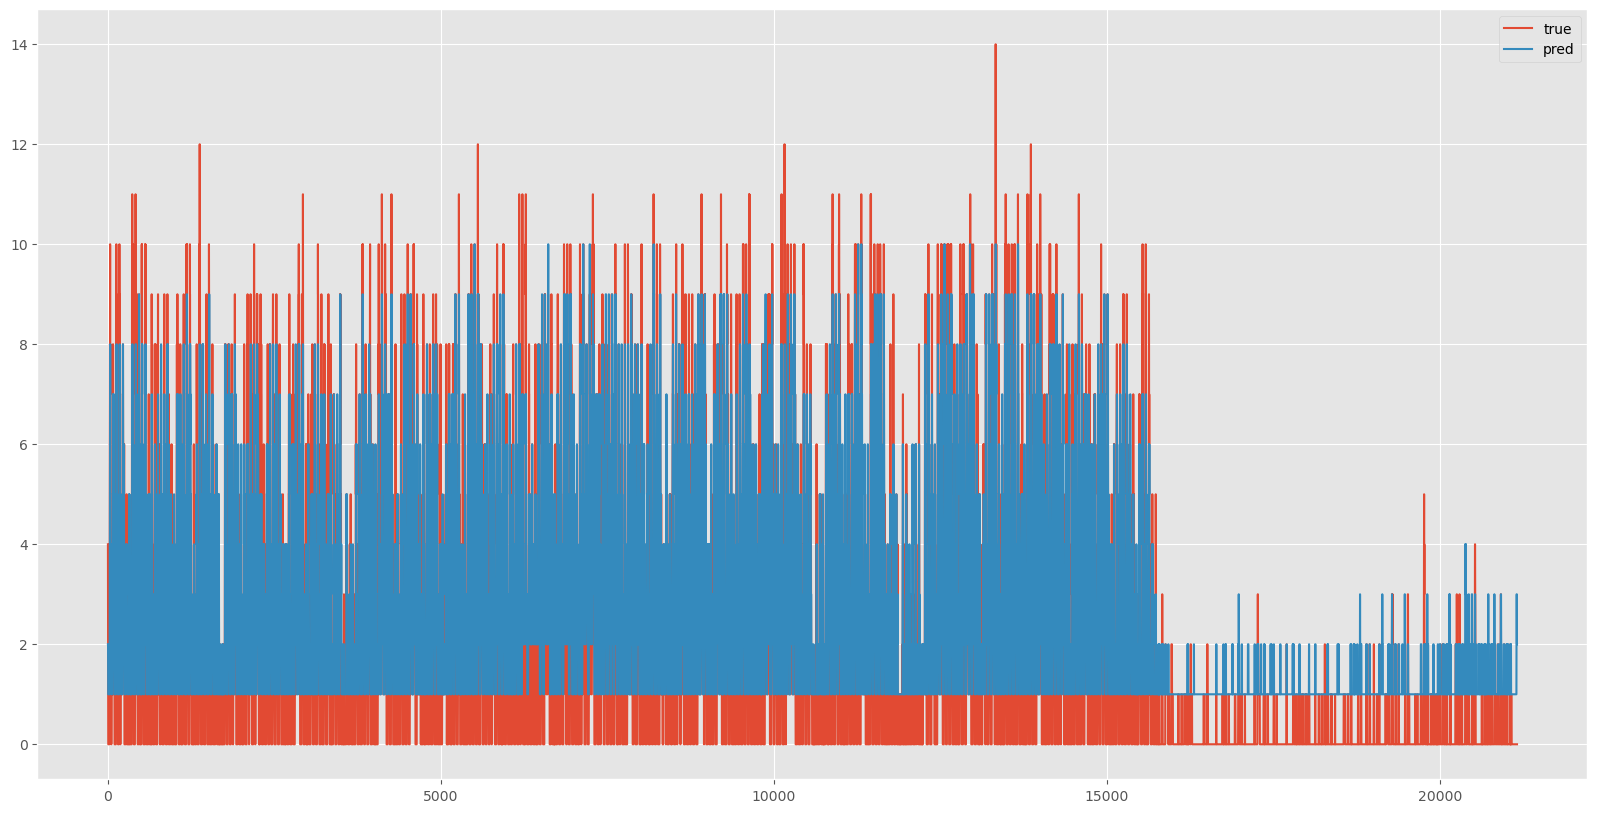

In [ ]:
plt.subplots(figsize=(20,10))
plt.plot(np.array(true)[:,0], label='true')
plt.plot(np.array(preds).round()[:,0], label='pred')
plt.legend()
plt.show()

In [ ]:
np.array(true)[:,0].shape

(20008,)

In [ ]:
df_sess.columns.difference(['Period'])

In [ ]:
d = np.arange(1, 31)

In [ ]:
set(np.array(preds).flatten())

{1.5643517}